In [ ]:
import torch
from torch import nn

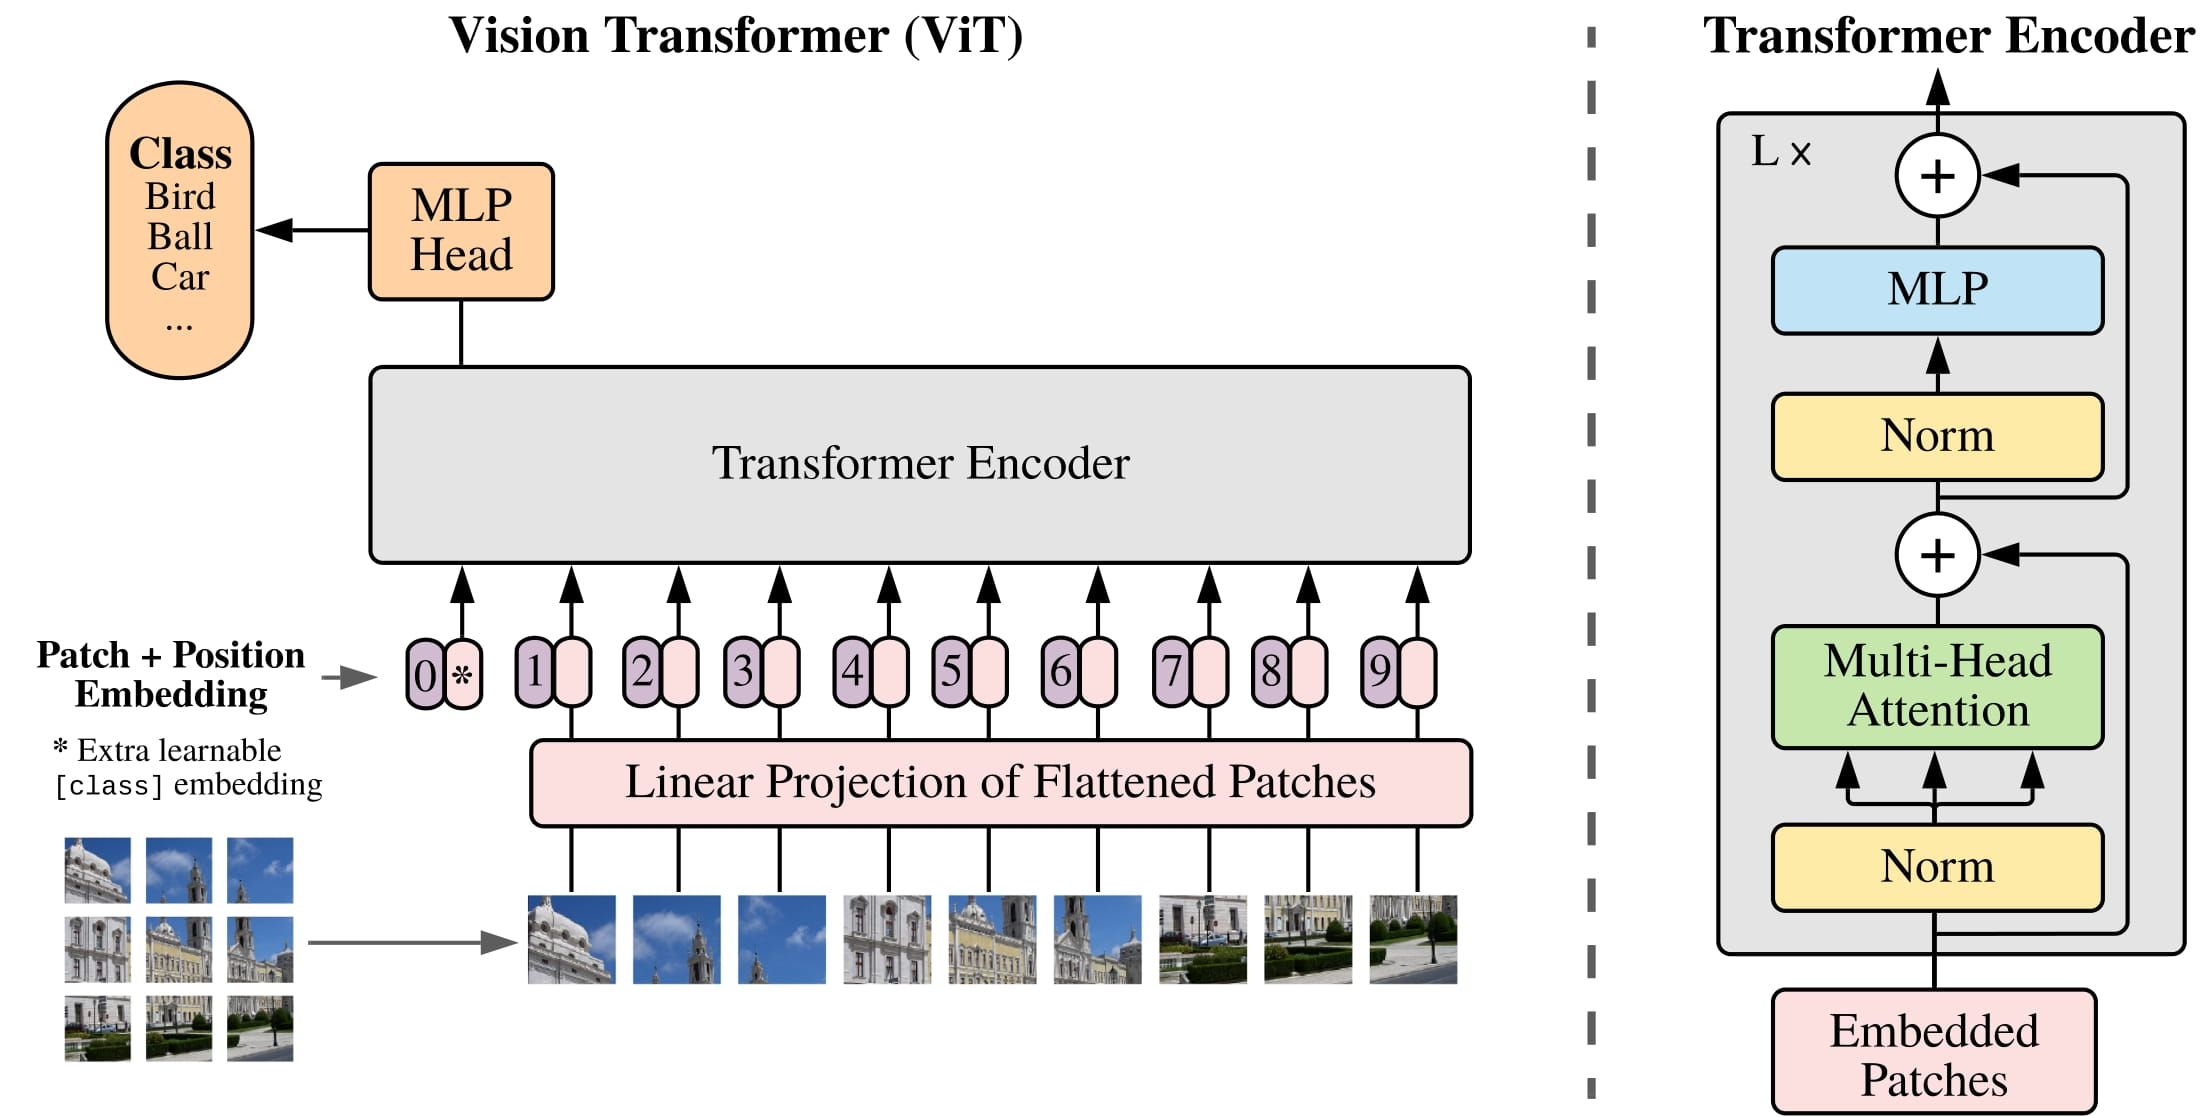

In [ ]:
def patch(batch, patch_size):
  batch_size, channels, height, width = batch.shape
  patch_height, patch_width = patch_size
  batch_patches = torch.reshape(batch, (batch_size, channels, height//patch_height, patch_height,
                                        width//patch_width, patch_width))
  return torch.permute(batch_patches, (0,1,2,4,3,5))

In [ ]:
def build_mlp(in_features, hidden_units, out_features):
  dims = [in_features] + hidden_units + [out_features]
  layers = []
  for dim1, dim2 in zip(dims[:-2], dims[1:-1]):
    layers.append(nn.Linear(dim1, dim2))
    layers.append(nn.ReLU())

  layers.append(nn.Linear(dims[-2], dims[-1]))
  return nn.Sequential(*layers)

In [ ]:
class image_to_sequence(nn.Module):
  '''
  input -> (b,h,w,c)
  output -> (b,s,d)
  '''

  def __init__(self, img_size, patch_size, n_channels, d_model):
    super().__init__()
    self.patch_size = patch_size
    self.img_size = img_size

    nh,nw = img_size[0]//patch_size[0], img_size[1]//patch_size[1]

    n_tokens = nh*nw
    token_dim = patch_size[0]*patch_size[1]*n_channels
    self.linear = nn.Linear(token_dim, d_model)
    self.cls_token = nn.Parameter(torch.randn(1,1, d_model))
    self.pos_emb = nn.Parameter(torch.randn(n_tokens, d_model))

  def __call__(self, batch):
    batch = patch(batch, self.patch_size)
    b,c,nh,nw,ph,pw = batch.shape

    batch = torch.permute(batch, [0,2,3,4,5,1])
    batch = torch.reshape(batch, [b, nh*nw, ph*pw*c])

    batch = self.linear(batch)
    cls = self.cls_token.expand([b, -1, -1])
    emb = batch + self.pos_emb

    return torch.cat([cls, emb], axis=1)

In [ ]:
class ViT(nn.Module):
  def __init__(self,
               img_size,
               patch_size,
               n_channels,
               d_model,
               nheads,
               dim_feedforward,
               blocks,
               mlp_head_units,
               n_classes):
    super().__init__()
    self.img2seq = image_to_sequence(img_size, patch_size, n_channels, d_model)
    encoder_layer = nn.TransformerEncoderLayer(
        d_model, nheads, dim_feedforward, activation='gelu',
        batch_first=True
    )
    self.transform_encoder = nn.TransformerEncoder(encoder_layer, blocks)
    self.mlp = build_mlp(d_model, mlp_head_units, n_classes)

    self.output = nn.Softmax() if n_classes>1 else nn.Sigmoid()

  def __call__(self, batch):
    batch = self.img2seq(batch)
    batch = self.transformer_encoder(batch)
    batch = batch[:, 0, :]
    batch = self.mlp(batch)
    output = self.output(batch)
    return output

In [ ]:
model_config = {
    'img_size': (512, 512),
    'patch_size': (16,16),
    'n_channels': 1,
    'd_model': 1024,
    'nheads': 4,
    'dim_feedforward': 2048,
    'blocks': 8,
    'mlp_head_units': [1024, 512],
    'n_classes':1
}

In [ ]:
model = ViT(
    **model_config
)